# Logistic regression Models

add main folder to path to access utils package

In [2]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

import modules 

In [3]:
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from utils.machine_learning import Rounder

In [4]:
train_data = pd.read_pickle("../../data/train_processed.pkl")
train_data

,PassengerNum,Age,HomePlanet,Destination,CabinDeck,CabinSide,CryoSleep,VIP,RoomService,FoodCourt,...,YesShoppingMall,YesSpa,YesVRDeck,YesTotalSpending,LogRoomService,LogFoodCourt,LogShoppingMall,LogSpa,LogVRDeck,LogTotalSpending
0,01,39.0,Europa,TRAPPIST-1e,B,P,False,False,0.0,0.0,...,False,False,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,01,24.0,Earth,TRAPPIST-1e,F,S,False,False,109.0,9.0,...,True,True,True,True,4.700480,2.302585,3.258097,6.309918,3.806662,6.602588
2,01,58.0,Europa,TRAPPIST-1e,A,S,False,True,43.0,3576.0,...,False,True,True,True,3.784190,8.182280,0.000000,8.812248,3.912023,9.248021
3,02,33.0,Europa,TRAPPIST-1e,A,S,False,False,0.0,1283.0,...,True,True,True,True,0.000000,7.157735,5.918894,8.110728,5.267858,8.551981
4,01,16.0,Earth,TRAPPIST-1e,F,S,False,False,303.0,70.0,...,True,True,True,True,5.717028,4.262680,5.023881,6.338594,1.098612,6.995766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,01,41.0,Europa,55 Cancri e,A,P,False,True,0.0,6819.0,...,False,True,True,True,0.000000,8.827615,0.000000,7.404888,4.317488,9.052165
8689,01,18.0,Earth,PSO J318.5-22,G,S,True,False,0.0,0.0,...,False,False,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8690,01,26.0,Earth,TRAPPIST-1e,G,S,False,False,0.0,0.0,...,True,True,False,True,0.000000,0.000000,7.535297,0.693147,0.000000,7.535830
8691,01,32.0,Europa,55 Cancri e,E,S,False,False,0.0,1049.0,...,False,True,True,True,0.000000,6.956545,0.000000,5.869297,8.082093,8.442039


In [5]:
numerical_columns = list(
    train_data.select_dtypes(include="number").drop(columns="CabinBin")
)

<Axes: >

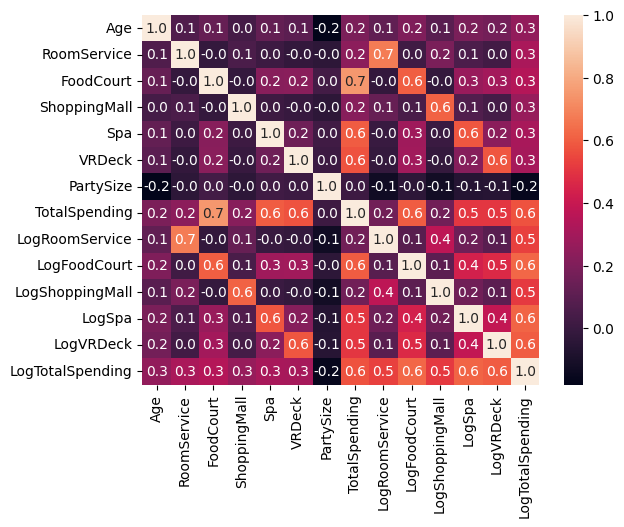

In [6]:
sns.heatmap(train_data[numerical_columns].corr(), annot=True, fmt=".1f")

In [7]:
train_data.columns

Index(['PassengerNum', 'Age', 'HomePlanet', 'Destination', 'CabinDeck',
       'CabinSide', 'CryoSleep', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'NameMissing',
       'HomeMissing', 'DestinationMissing', 'CabinMissing', 'CryoMissing',
       'VIPMissing', 'PartySize', 'FamilyGroupMember', 'CabinBin',
       'TotalSpending', 'YesRoomService', 'YesFoodCourt', 'YesShoppingMall',
       'YesSpa', 'YesVRDeck', 'YesTotalSpending', 'LogRoomService',
       'LogFoodCourt', 'LogShoppingMall', 'LogSpa', 'LogVRDeck',
       'LogTotalSpending'],
      dtype='object')

In [8]:
df = train_data.copy()
X = df.drop(
    columns=[
        "Transported",
        "TotalSpending",
        "LogRoomService",
        "LogFoodCourt",
        "LogShoppingMall",
        "LogSpa",
        "LogVRDeck",
        "LogTotalSpending",
        "YesRoomService",
        "YesFoodCourt",
        "YesShoppingMall",
        "YesSpa",
        "YesVRDeck",
        "YesTotalSpending",
    ]
)
y = df["Transported"]
numerical_columns = list(X.select_dtypes(include="number").drop(columns="CabinBin"))
categorical_columns = list(X.select_dtypes(include=["object"]))
set_config(transform_output="pandas")

cat_pipeline = Pipeline([("one_hot", OneHotEncoder(sparse_output=False))])
num_pipeline = Pipeline(
    [
        ("imputer", IterativeImputer(random_state=0)),
        ("scaler", StandardScaler()),
    ]
)
ord_pipeline = Pipeline(
    [
        ("oe", OrdinalEncoder()),
        ("imputer", IterativeImputer(random_state=0)),
        ("rounder", Rounder(decimals=0)),
    ]
)
feature_preprocessing = ColumnTransformer(
    [
        ("cat", cat_pipeline, categorical_columns),
        ("num", num_pipeline, numerical_columns),
        ("ord", ord_pipeline, ["CabinBin"]),
    ],
    verbose_feature_names_out=False,
)

In [9]:
X_processed = feature_preprocessing.fit_transform(X)

In [13]:
model = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_processed, y, scoring="accuracy", cv=cv, n_jobs=-1)
mean_acc = np.mean(n_scores)
std_acc = np.std(n_scores)
print(f"Accuracy: {mean_acc:.3f} (std. dev. {std_acc:.3f})")

Accuracy: 0.790 (std. dev. 0.012)


In [14]:
def objective(trial, data=X_processed, target=y):
    data = data.copy()

    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga"])

    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", "none"])

    if solver == "lbfgs" and penalty != "l2":
        raise optuna.exceptions.TrialPruned()
    if solver == "liblinear" and penalty == "elasticnet":
        raise optuna.exceptions.TrialPruned()
    if solver == "liblinear" and penalty == "none":
        raise optuna.exceptions.TrialPruned()

    l1_ratio = None
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    C = trial.suggest_float("C", 1e-6, 1e2, log=True)
    max_iter = trial.suggest_int("max_iter", 100, 1000)
    tol = trial.suggest_float("tol", 1e-6, 1e2, log=True)

    model = LogisticRegression(
        solver=solver,
        penalty=penalty,
        C=C,
        max_iter=max_iter,
        tol=tol,
        l1_ratio=l1_ratio,
        random_state=42,
    )

    score = cross_val_score(model, data, target, scoring="accuracy", cv=5).mean()

    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

trial = study.best_trial

print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-10-17 23:25:53,243] A new study created in memory with name: no-name-da01f0a5-b425-405d-b6db-be9467523c7b
[I 2024-10-17 23:25:53,303] Trial 0 pruned. 
[I 2024-10-17 23:25:53,339] Trial 1 pruned. 
[I 2024-10-17 23:25:53,528] Trial 2 finished with value: 0.4963764342164557 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.00017925107379174543, 'max_iter': 462, 'tol': 0.4953579341453391}. Best is trial 2 with value: 0.4963764342164557.
[I 2024-10-17 23:25:53,700] Trial 3 finished with value: 0.7656744250065015 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.00010004431746241983, 'max_iter': 776, 'tol': 0.07630600866183312}. Best is trial 3 with value: 0.7656744250065015.
[I 2024-10-17 23:25:53,707] Trial 4 pruned. 
[I 2024-10-17 23:25:53,712] Trial 5 pruned. 
/Users/migueldiaz/Documents/datascience/projects_for_github/spaceship_titanic_prediction/spaceship_titanic/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_i

Accuracy: 0.7896013806328914
Best hyperparameters: {'solver': 'saga', 'penalty': 'l1', 'C': 34.740952283871906, 'max_iter': 275, 'tol': 1.601598205514012e-05}


In [17]:
model = LogisticRegression(
    **{
        "solver": "saga",
        "penalty": "l1",
        "C": 34.740952283871906,
        "max_iter": 3000,
        "tol": 1.601598205514012e-05,
    }
)
log_reg_pipeline = Pipeline(
    steps=[("preprocessor", feature_preprocessing), ("model", model)]
)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cross_val_score(
    log_reg_pipeline, X, y, scoring="accuracy", n_jobs=-1, cv=5, error_score="raise"
).mean()

/Users/migueldiaz/Documents/datascience/projects_for_github/spaceship_titanic_prediction/spaceship_titanic/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/migueldiaz/Documents/datascience/projects_for_github/spaceship_titanic_prediction/spaceship_titanic/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/migueldiaz/Documents/datascience/projects_for_github/spaceship_titanic_prediction/spaceship_titanic/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7891413461303038

In [18]:
import pickle

model = log_reg_pipeline
model.fit(X, y)

with open(
    "../../ML_models_trained/log_reg_model.pkl",
    "wb",
) as file:
    pickle.dump(model, file)

/Users/migueldiaz/Documents/datascience/projects_for_github/spaceship_titanic_prediction/spaceship_titanic/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
